In [1]:
import cantera as ct
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

# Burner Flame Example

In this example, we will demonstrate a burner flame at two equivalence ratios, one with a flame attached to the burner surface, and one where the flame blows off. We will also demonstrate the ability of the Cantera solver to have arbitrary functions inserted to collect data and control the simulation. First, we define a function to set up the flame with the equivalence ratio as a parameter.

In [2]:
def setup(phi):
    # parameter values
    p = ct.one_atm  # pressure
    tburner = 300.0  # burner temperature
    mdot = 1.2 # kg/m^2/s
    width = 0.05 # m

    gas = ct.Solution('h2o2.cti')

    # set state to that of the unburned gas at the burner
    gas.set_equivalence_ratio(phi, 'H2', 'O2:1.0, AR:5')
    gas.TP = tburner, p

    # Create the stagnation flow object with a non-reactive surface.
    sim = ct.BurnerFlame(gas=gas, width=width)
    # set the mass flow rate at the inlet
    sim.burner.mdot = mdot
    sim.set_refine_criteria(ratio=3, slope=0.16, curve=0.3, prune=0.1)
    return sim

Now we create a simulation with the equivalence ratio $\phi = 0.6$ which is above the lean blowoff limit for this flame.

In [3]:
sim = setup(0.6)
sim.solve(loglevel=1, auto=True)


************ Solving on 7 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [7] point grid(s).

..............................................................................
grid refinement disabled.

******************** Solving with grid refinement enabled ********************

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [7] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 
    to resolve AR H H2 H2O H2O2 HO2 O O2 OH T u 
##############################################################################

.........

If we plot the temperature on the grid, we will find that the product temperature approaches the equilibrium temperature downstream, indicating a successfully attached flame.

<IPython.core.display.Javascript object>


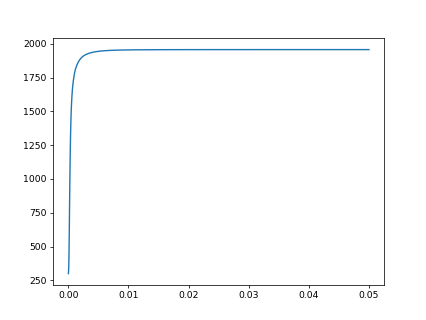

In [4]:
fig, ax = plt.subplots(1, 1)
ax.plot(sim.grid, sim.T)

On the other hand, let's set up a flame now that blows off the burner. For this case, we will use the equivalence ratio $\phi = 0.4$.

In [5]:
sim = setup(0.4)
sim.solve(loglevel=1, auto=True)


************ Solving on 7 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     7.594e-05      5.411
Attempt Newton solution of steady-state problem...    success.

Problem solved on [7] point grid(s).

..............................................................................
grid refinement disabled.

******************** Solving with grid refinement enabled ********************

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [7] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 
    to resolve AR H H2 H2O H2O2

Take 10 timesteps     0.0001442      5.735
Attempt Newton solution of steady-state problem...    success.

Problem solved on [31] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 22 23 24 25 26 27 29 
    to resolve AR H H2 H2O H2O2 HO2 O O2 OH T point 24 point 29 u 
##############################################################################
refine: discarding point at 0.00375
refine: discarding point at 0.0134375
refine: discarding point at 0.0148437
refine: discarding point at 0.0157813
refine: discarding point at 0.016875
refine: discarding point at 0.0171875
refine: discarding point at 0.0175
refine: discarding point at 0.018125
refine: discarding point at 0.01875

..............................................................................
Attempt Newton solution of steady-state problem..

Take 10 timesteps     0.0001922      5.931
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001442      5.709
Attempt Newton solution of steady-state problem...    success.

Problem solved on [36] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 26 27 28 29 30 31 
    to resolve AR H H2 H2O H2O2 HO2 O O2 OH T u 
##############################################################################
refine: discarding point at 0.0121875
refine: discarding point at 0.0215625
refine: discarding point at 0.0240625
refine: discarding point at 0.0275
refine: discarding point at 0.0282812
refine: discarding point at 0.029375
refine: discarding point at 0.0296875
refine: discarding point at 0.03
refine: discarding point at 0.030625
refine: discarding point at 0.03125

.......

Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001139      6.041
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001442      6.046
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001825      5.822
Attempt Newton solution of steady-state problem...    success.

Problem solved on [35] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 28 29 30 31 32 
    to resolve AR H H2 H2O H2O2 HO2 O O2 OH T u 
##############################################################################
refine: discarding point at 0.0290625
refine: discarding point at 0.0364062
refine: discarding point at 0.03875
refine: discarding point at 0.040625
refine: discarding point at 0.0410937
refine: discarding po

Hmm, we only ended up with 25 points in the flame. This is strange, so we can add a `callback` function to investigate the progress of the solver as the simulation progresses. We have two options, one which calls the `callback` function after every steady state solve, while the other calls the `callback` function after every transient solve. In this case, we will use the function

```
set_steady_callback(self, f)
    Set a callback function to be called after each successful steady-state solve, before regridding. The signature of f is float f(float). The argument passed to f is “0” and the output is ignored.
```

So, we need to define a function that takes one argument, which will always be the value `0`. On the other hand, we can use global variables within the `callback` function. In this case, we want to plot the temperature profile after every steady solver step, so we can track the progress of the solution.

<IPython.core.display.Javascript object>


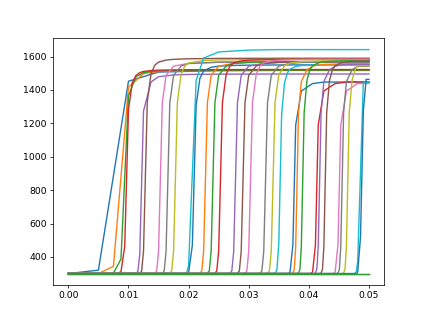

In [6]:
# Use callback function to collect and plot data after each steady solve
fig, ax = plt.subplots(1, 1)

def callback(x):
    """
    Callback function that plots the simulation temperature.
    The argument ``x`` is not used.
    """
    ax.plot(sim.grid, sim.T)
    fig.canvas.draw()
    return 0

In [7]:
sim = setup(0.4)

sim.set_steady_callback(callback)
sim.solve(loglevel=0, auto=False)